In [11]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

In [64]:
import io
import tarfile
import requests
import rasterio
from rasterio.plot import show
from matplotlib import pyplot
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

In [105]:
input_bands = ["B02", "B03", "B04","B08"]
masks = ["SCL", "dataMask"] # SCL ... Scene Classification Layer
indices = ['NDVI']
output_bands = input_bands + indices

output_array =  ','.join([f"{{id: '{ob}', bands: 4, sampleType: SampleType.UINT16}}" for ob in output_bands])

results_object = '{' + ','.join([f'{ob}: []' for ob in output_bands]) + '}'
debug_results = '{' + ','.join([f"{output_bands[i]}: [{i+1}]" for i in range(5)]) + '}'

'{B02: [],B03: [],B04: [],B08: []}'

In [94]:
url = "https://services.sentinel-hub.com/api/v1/process"

#double curly brackets render as single curly brackets in f-strings
evalscript = f"""
    //VERSION=3
    function setup(ds) {{
      return {{
        input: [{{
          bands: {str(input_bands + masks)}, 
          units: "DN"
        }}],
        output: [        
          {output_array}
        ],
        mosaicking: Mosaicking.ORBIT       
      }}
    }}

    function validate (sample) {{
      if (sample.dataMask!=1) return false;

      var scl = Math.round(sample.SCL);

      if (scl === 3) {{ // SC_CLOUD_SHADOW
        return false;
      }} else if (scl === 9) {{ // SC_CLOUD_HIGH_PROBA
        return false; 
      }} else if (scl === 8) {{ // SC_CLOUD_MEDIUM_PROBA
        return false;
      }} else if (scl === 7) {{ // SC_CLOUD_LOW_PROBA
        //return false;
      }} else if (scl === 10) {{ // SC_THIN_CIRRUS
        return false;
      }} else if (scl === 11) {{ // SC_SNOW_ICE
        return false;
      }} else if (scl === 1) {{ // SC_SATURATED_DEFECTIVE
        return false;
      }} else if (scl === 2) {{ // SC_DARK_FEATURE_SHADOW
        //return false;
      }}
      return true;
    }}

    function calculateIndex(a,b)
    {{
      if ((a+b)==0) return 0;
      var val = (a-b)/(a+b);
      if (val<0) val = 0;
      //TODO - we might need to return false instead of 0; depends on the output format - a value needs to be designated as "null"
      return val;
    }}

    function interpolatedValue(arr)
    {{
      //here we define the function on how to define the proper value - e.g. linear interpolation; we will use average 
      if (arr.length==0) return 0;
      if (arr.length==1) return arr[0];
      var sum = 0;
      for (i=0;i<arr.length;i++)
        {{sum+=arr[i];}}
      return Math.round(sum/arr.length);
    }}
    
    var results = {results_object}

    function evaluatePixel(samples, scenes, inputMetadata, customData, outputMetadata) {{

      //Debug part returning "something" if there are no  valid samples (no observations)
      if (!samples.length)
      return {debug_results}

      var interval = 14; //interval length in days
      var startDate = scenes[0].date.getTime();
      var interval_number = 0;

      var int_b02 = [];
      var int_b03 = [];
      var int_b04 = [];
      var int_b08 = [];
      var int_ndvi = [];

      for (var i = 0; i < samples.length; i++) {{
        //TODO order should be reversed when we go leastRecent
        if (startDate-scenes[i].date.getTime()>interval*24*3600*1000)
        {{
          fillResultArray(interval_number, {{B02: int_b02, B03: int_b03, B04: int_b04, B08: int_b08 }})

          //reset values
          int_b02 = [];
          int_b03 = [];
          int_b04 = [];
          int_b08 = [];
          int_ndvi = [];

          startDate = scenes[i].date.getTime();
          interval_number++;
        }}

        if (validate(samples[i]))
        {{
          int_b02.push(samples[i].B02);
          int_b03.push(samples[i].B03);
          int_b04.push(samples[i].B04);
          int_b08.push(samples[i].B08);
        }}

      }}

      //execute this for the last interval 
      fillResultArray(interval_number, {{B02: int_b02, B03: int_b03, B04: int_b04, B08: int_b08 }});

      return results
    }}

    function fillResultArray(interval_number, int_bands)
    {{
      for (var b in int_bands) {{
        if(int_bands[b].length==0) results[b][interval_number] = 0
        else results[b][interval_number] = interpolatedValue(int_bands[b])
      }}
      
      for (var ix of {indices}) {{
        results[ix][interval_number] = 65535*calculateIndex(results['B08'][interval_number],results['B04'][interval_number])
      }}
    }}
"""
print(evalscript)


    //VERSION=3
    function setup(ds) {
      return {
        input: [{
          bands: ['B02', 'B03', 'B04', 'B08', 'SCL', 'dataMask'], 
          units: "DN"
        }],
        output: [        
          {id: 'B02', bands: 4, sampleType: SampleType.UINT16},{id: 'B03', bands: 4, sampleType: SampleType.UINT16},{id: 'B04', bands: 4, sampleType: SampleType.UINT16},{id: 'B08', bands: 4, sampleType: SampleType.UINT16},{id: 'NDVI', bands: 4, sampleType: SampleType.UINT16}
        ],
        mosaicking: Mosaicking.ORBIT       
      }
    }

    function validate (sample) {
      if (sample.dataMask!=1) return false;

      var scl = Math.round(sample.SCL);

      if (scl === 3) { // SC_CLOUD_SHADOW
        return false;
      } else if (scl === 9) { // SC_CLOUD_HIGH_PROBA
        return false; 
      } else if (scl === 8) { // SC_CLOUD_MEDIUM_PROBA
        return false;
      } else if (scl === 7) { // SC_CLOUD_LOW_PROBA
        //return false;
      } else if (scl === 10) { // SC_THI

In [95]:
%%time

payload = {
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            },
            "bbox": [16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863]
        },
        "data": [
            {
                "type": "S2L2A",
                "dataFilter": {
                    "timeRange": {
                        "from": "2018-07-01T00:00:00Z",
                        "to": "2018-07-31T23:59:59Z"
                    },
            "mosaickingOrder": "mostRecent",
            "maxCloudCoverage": 100,
            "previewMode": "DETAIL"
                }
            }
        ]
    },
    "output": {
                "width": 512,
                "height": 512,
                "responses": [
                        {
                "identifier": "B02",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B03",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B04",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B08",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "NDVI",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "userdata",
                "format": {
                    "type": "application/json"
                }
            }
        ]
    },
    "evalscript": evalscript,
    "tilingGridId": 0,
    "bucketName": "eox-sentinelhub-batch",
    "resolution": 40.0,
    "description": "Test Loipersbach"
}

headers = {
  'Accept': 'application/tar'
}

response = oauth.request("POST", url, headers=headers, json = payload)

if response.status_code != requests.codes.ok:
    print(response.json()['error'])

CPU times: user 25.8 ms, sys: 140 µs, total: 25.9 ms
Wall time: 10.9 s


-rw-r--r-- 0/0     742674 2020-03-18 14:39:34 B02.tif 
-rw-r--r-- 0/0     762440 2020-03-18 14:39:34 B03.tif 
-rw-r--r-- 0/0     771167 2020-03-18 14:39:34 B04.tif 
-rw-r--r-- 0/0     857008 2020-03-18 14:39:34 B08.tif 
-rw-r--r-- 0/0     982781 2020-03-18 14:39:34 NDVI.tif 
-rw-r--r-- 0/0          4 2020-03-18 14:39:34 userdata.json 


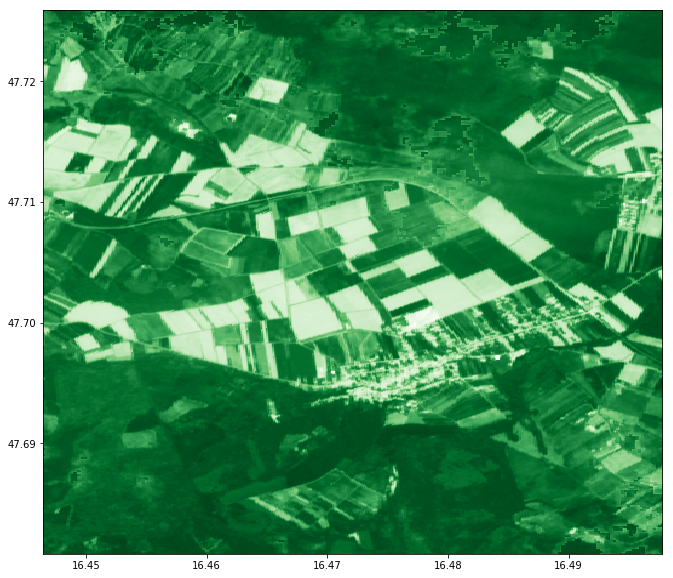

In [98]:
file = io.BytesIO(response.content)
tar = tarfile.open(fileobj=file, mode="r")
tar.list()
tar.extractall('../testing/')#('B04.tif', '../testing/')
with rasterio.open(tar.extractfile('NDVI.tif')) as tif:
    pyplot.figure(figsize=(16,10))
    show((tif,1), transform=tif.transform, cmap='Greens')